In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import random
from sklearn.preprocessing import LabelEncoder
import os

In [2]:

pos_df = pd.read_csv('positive10k.txt', sep='\t', header=None) 
neg_df = pd.read_csv('negative10k.txt', sep='\t', header=None)
cmt_msg_df = pd.read_csv('commit-messages.txt', sep='\t', header=None) 

pos_df.shape, neg_df.shape, cmt_msg_df.shape

((9935, 1), (9719, 1), (14195, 1))

In [3]:
pos_df[1]='positive'
neg_df[1]='negative'
cmt_msg_df[1]='enhancement'

In [4]:
df = pd.DataFrame(pos_df)
df = df.append(neg_df)
df = df.append(cmt_msg_df[:10000])
df.shape

(29654, 2)

In [5]:
df = df.sample(frac = 1, random_state = 42)
df

,0,1
5977,consumed as system properties in log4j2.xml an...,enhancement
4810,The afterResolve action would then try to acce...,enhancement
9859,"This partially reverts commit 1f8ea54c.,Upgrad...",enhancement
8643,I like it a lot I like that you can go on diff...,positive
6432,"Polish ""Configure SAML 2.0 Service Provider vi...",enhancement
...,...,...
1921,Align buildSrc's Kotlin version with main proj...,enhancement
5390,Love these games,positive
860,Good game I can play it but i wish it didn't h...,positive
5860,Poor Navigation is nice but hard to use if com...,negative


<AxesSubplot:>

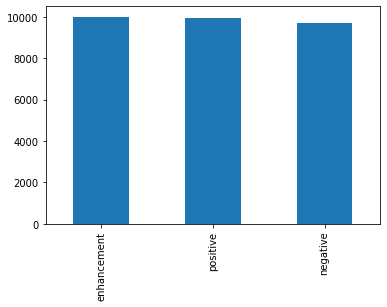

In [6]:
df[1].value_counts().plot(kind='bar')


In [7]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df[0].to_numpy(),
                                                                            df[1].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(23723, 23723, 5931, 5931)

In [8]:
max_vocab_length = 10000
avg_sentence_length = int(np.mean([len(s.split()) for s in train_sentences]))
avg_sentence_length

15

In [9]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                     standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    output_sequence_length=avg_sentence_length)
text_vectorizer.adapt(train_sentences)

2022-02-20 21:40:17.191656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 21:40:17.219355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 21:40:17.219818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 21:40:17.221123: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [10]:
# integer encode
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(val_labels)
y_train[0],y_test[0]

(0, 0)

In [11]:
train_sentences[0], val_sentences[0], y_train[0], y_test[0]

("See gh-22922,Update BootRun to support Gradle's configuration cache",
 '  Polish "Support configuration of entityId for a SAML Relying Party"',
 0,
 0)

In [12]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = layers.Embedding(max_vocab_length, 128)(x) # create an embedding of the numerized numbers
#x = layers.GRU(128)(x) # create a GRU layer with 128 units
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.9, recurrent_dropout=0.9))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(32, dropout=0.7, recurrent_dropout=0.9))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [13]:
with tf.device('/cpu:0'):
    model_history = model.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                                y_train,
                                epochs=5,
                                verbose=1,
                                validation_data=(val_sentences, y_test))

Epoch 1/5
742/742 [==============================] - 93s 113ms/step - loss: 0.5004 - accuracy: 0.7712 - val_loss: 0.2452 - val_accuracy: 0.9027
Epoch 2/5
742/742 [==============================] - 84s 113ms/step - loss: 0.2608 - accuracy: 0.8977 - val_loss: 0.2252 - val_accuracy: 0.9154
Epoch 3/5
742/742 [==============================] - 84s 113ms/step - loss: 0.2132 - accuracy: 0.9214 - val_loss: 0.2138 - val_accuracy: 0.9187
Epoch 4/5
742/742 [==============================] - 84s 113ms/step - loss: 0.1898 - accuracy: 0.9307 - val_loss: 0.2149 - val_accuracy: 0.9219
Epoch 5/5
742/742 [==============================] - 84s 113ms/step - loss: 0.1744 - accuracy: 0.9376 - val_loss: 0.2230 - val_accuracy: 0.9181


In [24]:
prediction=model.predict(["ux experience is very good"])
label_encoder.inverse_transform([np.argmax(prediction)])

array(['positive'], dtype=object)